## DataQuest Guided Project

## Exploring Popular Data Science Questions

### Navigation

[Introduction](#Introduction)

[Stack Exchange Site Features](#Stack-Exchange-Features)

[Stack Exchange Data Explorer (SEDE)](#Stack-Exchange-Data-Explorer-(SEDE))

[Data Exploration in Pandas](#Data-Exploration-in-Pandas)

[Data Transformation in Pandas](#Data-Transformation)

[Calculating Tag Popularity](#Calculating-Tag-Popularity)

[Visualizing Tag Popularity](#Visualizing-Tag-Popularity)

[Analyzing and Visualizing Tag Relationships](#Analyzing-and-Visualizing-Tag-Relationships)

[Analyzing the Deep Learning Trend](#Analyzing-the-Deep-Learning-Trend)

[Analyzing the Popularity of Python and R Over Time](#Analyzing-the-Popularity-of-Python-and-R-Over-Time)

[Conclusion](#Conclusion)

### Introduction

The goal of this project is to figure out the best topic to write about for a company that creates data science content. There is more than one approach to address our goal because there is no single definition of "best". The approach we will take here is to investigate popular topics posted on the [Data Science Stack Exchange (DSSE)](https://datascience.stackexchange.com/).

As of the time of this writing (1-21-21), 67% of questions posted to DSSE were answered according to the [list of Stack Exchange sites](https://stackexchange.com/sites?view=list#percentanswered). The list contains 176 sites (you can get this by viewing the page source in Chrome browser and searching for string `class="site-icon`. My search box found 176 matches, a quick use of the text search feature to web scrape useful information. Other browsers may be capable of showing you the number of matches as well). 

DSSE ranks 13th from the bottom in the list of 176 sites in percentage of questions answered. This may indicate an opportunity to write content on data science topics.

### Stack Exchange Features

Before we go deeper, it is important to have a basic understanding of how a Stack Exchange site works. Simply put, any given Stack Exchange site is a question-answer site dedicated to a topic in a variety of categories, such as technology, culture, language, science, recreation, professional, and business. Here are some additional points explaining how a site works:

* Any user can ask a question, and any user can answer
* Questions and answers can receive upvotes and downvotes from users
* The default sorting method for questions is to show new questions or replies at the top
* "Hot" sorting method allows to sort questions by the number of answers, views, and votes instead
* Active and helpful users earn reputation points
* Questions have to be on topic
* Subjective questions are discouraged unless they are constructive, for example they may invite answers that explain "Why" and "How", or the sharing of experiences over opinions
* Questions with a scope that is too broad or with a goal to start a discussion rather than look for an answer are not welcomed
* Duplicate questions are marked as such by site's moderators

DSSE home page has a number of elements besides the questions list:

* search bar with text input
* links to tags, users, unanswered questions, and jobs (not all sites have a job board)
* links to popular questions from other sites
* links to site-specific chat where questions and discussion rules are more relaxed

Each question page has additional elements besides the question itself:

* upvote / downvote icons
* number of views - this may be useful in reaching our goal
* comments from other users that are tied to the question - usually requests for additional information or clarification
* answers from other users intending to answer the question at hand

We can keep things simple and analyze tags by the following criteria:

* Number of tag appearances (Frequency of tags)
* Number of views

[To Top](#Navigation)

### Stack Exchange Data Explorer (SEDE)

Stack Exchange provides a public-facing database for each site that enables efficient data analysis without having to scrape the sites.

Here is the link to the [Data Science Stack Exchange Data Explorer](https://data.stackexchange.com/datascience/query/new) that accepts Transact-SQL queries. Transact-SQL is a SQL dialect that is different from SQLite.

The database schema is below.

View database schema in full resolution [here](https://i.stack.imgur.com/AyIkW.png)

![Database Schema](https://i.stack.imgur.com/AyIkW.png)

These are some tables that may be useful. "Posts" refer to questions as well as answers, among other actions users can take on the site:

* Posts
* PostTags
* PostTypes
* PostFeedback
* Tags
* VoteTypes

Query to view top 5 most frequently used tags:

<code>
SELECT TOP 5 *
  FROM Tags
 ORDER BY Count DESC;
</code>

|Id|TagName|Count|ExcerptPostId|WikiPostId|
|---|---|---|---|---|
|2|machine-learning|8546|4909|4908|
|46|python|4960|5523|5522|
|81|neural-network|3553|8885|8884|
|194|deep-learning|3544|8956|8955|
|77|classification|2425|4911|4910|

Query to view post types. Question (Id 1) and Answer (Id 2) may be of interest to us:

<code>
SELECT *
  FROM PostTypes;
</code>

|Id|Name|
|---|---|
|1|Question|
|2|Answer|
|3|Wiki|
|4|TagWikiExcerpt|
|5|TagWiki|
|6|ModeratorNomination|
|7|WikiPlaceholder|
|8|PrivilegeWiki|

We need to limit our timeframe to ignore any old data that may be outdated and irrelevant to the question we are trying to answer.

Query to view the most recent post creating date:

<code>
SELECT MAX(CreationDate)
  FROM Posts;
</code>

|Results|
|---|
|2021-01-17 00:44:21

It appears that we have data through Jan 16, 2021. Let's go ahead and analyze posts created after 2020 only.

Query to select posts that are either questions (PostTypeId 1) or answers (2) data after Dec 31, 2019:

<code>
SELECT Id,
       PostTypeId,
       CreationDate,
       Score,
       ViewCount,
       Tags,
       AnswerCount,
       FavoriteCount
  FROM Posts
 WHERE (CreationDate BETWEEN '20200101' AND (SELECT MAX(CreationDate)
                                               FROM Posts))
   AND (PostTypeId BETWEEN 1 AND 2);
</code>

|Id|PostTypeId|CreationDate|Score|ViewCount|Tags|AnswerCount|FavoriteCount|
|---|---|---|---|---|---|---|---|
|80726|2|8/24/2020  12:47:49 PM|0|||||
|80727|1|8/24/2020  1:27:36 PM|0|82|<feature-selection><feature-engineering><feature-scaling><dbscan><one-hot-encoding>|1||
|80729|1|8/24/2020  2:06:32 PM|3|96|<neural-network><deep-learning><lstm><natural-language-process><gan>|2||
|80730|1|8/24/2020  2:08:20 PM|1|44|<machine-learning><classification><logistic-regression><svm><one-hot-encoding>|1|1|
|80731|1|8/24/2020  2:19:01 PM|9|201|<feature-selection><feature-engineering><predictor-importance>|2|1|
|...||||||||
    
The data explorer allows query results to be explorted in a .csv format. Let's save this query result in a file named `2020_questions.csv`

[To Top](#Navigation)

### Data Exploration in Pandas

Load `2020_questions.csv` into a pandas dataframe for further exploration and analysis.

In [1]:
import numpy as np
import pandas as pd

posts_df = pd.read_csv('2020_questions.csv')
posts_df['CreationDate'] = posts_df['CreationDate'].astype('datetime64')

In [2]:
posts_df.head(10)

,Id,PostTypeId,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,80720,2,2020-08-24 08:43:00,3,NaN,NaN,NaN,NaN
1,80721,2,2020-08-24 08:54:00,1,NaN,NaN,NaN,NaN
2,80723,2,2020-08-24 09:36:00,0,NaN,NaN,NaN,NaN
3,80724,2,2020-08-24 12:01:00,0,NaN,NaN,NaN,NaN
4,80725,2,2020-08-24 12:03:00,0,NaN,NaN,NaN,NaN
5,80726,2,2020-08-24 12:47:00,0,NaN,NaN,NaN,NaN
6,80727,1,2020-08-24 13:27:00,0,82.0,<feature-selection><feature-engineering><featu...,1.0,NaN
7,80729,1,2020-08-24 14:06:00,3,96.0,<neural-network><deep-learning><lstm><natural-...,2.0,NaN
8,80730,1,2020-08-24 14:08:00,1,44.0,<machine-learning><classification><logistic-re...,1.0,1.0
9,80731,1,2020-08-24 14:19:00,9,201.0,<feature-selection><feature-engineering><predi...,2.0,1.0


Explore missing values by column

In [3]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             15286 non-null  int64         
 1   PostTypeId     15286 non-null  int64         
 2   CreationDate   15286 non-null  datetime64[ns]
 3   Score          15286 non-null  int64         
 4   ViewCount      7956 non-null   float64       
 5   Tags           7956 non-null   object        
 6   AnswerCount    7956 non-null   float64       
 7   FavoriteCount  958 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 955.5+ KB


We have multiple columns with missing values, but they have something to do with the type of post. Let's confirm.

In [4]:
posts_df.loc[posts_df['PostTypeId'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7956 entries, 6 to 15285
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7956 non-null   int64         
 1   PostTypeId     7956 non-null   int64         
 2   CreationDate   7956 non-null   datetime64[ns]
 3   Score          7956 non-null   int64         
 4   ViewCount      7956 non-null   float64       
 5   Tags           7956 non-null   object        
 6   AnswerCount    7956 non-null   float64       
 7   FavoriteCount  958 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 559.4+ KB


For PostTypeId 1 (Questions) we see that all columns have values except for the `FavoriteCount` column, which makes sense. In this case, we can replace NaNs with 0, which is the true number of times favorited.

In [5]:
mask_questions = posts_df['PostTypeId'] == 1
mask_zero_favorites = posts_df['FavoriteCount'].isna()
mask_combined = mask_questions & mask_zero_favorites
posts_df.loc[mask_combined, 'FavoriteCount'] = 0

posts_df.loc[posts_df['PostTypeId'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7956 entries, 6 to 15285
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7956 non-null   int64         
 1   PostTypeId     7956 non-null   int64         
 2   CreationDate   7956 non-null   datetime64[ns]
 3   Score          7956 non-null   int64         
 4   ViewCount      7956 non-null   float64       
 5   Tags           7956 non-null   object        
 6   AnswerCount    7956 non-null   float64       
 7   FavoriteCount  7956 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 559.4+ KB


For PostTypeId 2 (answers) we see that ViewCount, Tags, AnswerCount, and FavoriteCount fields are disabled, which is by design. These fields only apply to questions

In [6]:
posts_df.loc[posts_df['PostTypeId'] == 2].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7330 entries, 0 to 15284
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             7330 non-null   int64         
 1   PostTypeId     7330 non-null   int64         
 2   CreationDate   7330 non-null   datetime64[ns]
 3   Score          7330 non-null   int64         
 4   ViewCount      0 non-null      float64       
 5   Tags           0 non-null      object        
 6   AnswerCount    0 non-null      float64       
 7   FavoriteCount  0 non-null      float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 515.4+ KB


[To Top](#Navigation)

### Data Transformation

We see that multiple tags are squeezed into one column. Since we are interested in analyzing tags, we should transpose this column from wide to long format. First we will replace `<` and `>` symbols to make this easier, creating a comma separator instead

In [7]:
posts_df['Tags'] = posts_df['Tags'].str.replace('><', ',')
posts_df['Tags'] = posts_df['Tags'].str.replace('<', '')
posts_df['Tags'] = posts_df['Tags'].str.replace('>', '')

Expand tags from one column into multiple columns

In [8]:
post_ids = pd.DataFrame(posts_df['Id'])
tags_df = pd.concat([post_ids, posts_df['Tags'].str.split(pat=',', expand=True)], axis=1)
cols = [f'Tag_{col}' for col in tags_df.columns if col != 'Id']
cols.insert(0, 'Id')
tags_df.columns = cols

Remove original tag column and merge with new tag columns

In [9]:
posts_df.drop(columns='Tags', inplace=True)
posts_df = posts_df.merge(tags_df, left_on='Id', right_on='Id', how='inner')

Create a dataframe to analyze questions in a later stage of our analysis

In [10]:
questions_df = posts_df[posts_df['PostTypeId'] == 1]

In [11]:
posts_df = posts_df.melt(id_vars=['Id', 'PostTypeId', 'CreationDate', 'Score', 'ViewCount', 'AnswerCount', 'FavoriteCount'], 
                          value_vars=['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4'], value_name='Tag')
posts_df.drop(columns='variable', inplace=True)

Verify that our transformation worked as intended by filtering to one value from an earlier preview. We now have one tag per row as intended

In [12]:
posts_df[posts_df['Id'] == 80727]

,Id,PostTypeId,CreationDate,Score,ViewCount,AnswerCount,FavoriteCount,Tag
6,80727,1,2020-08-24 13:27:00,0,82.0,1.0,0.0,feature-selection
15292,80727,1,2020-08-24 13:27:00,0,82.0,1.0,0.0,feature-engineering
30578,80727,1,2020-08-24 13:27:00,0,82.0,1.0,0.0,feature-scaling
45864,80727,1,2020-08-24 13:27:00,0,82.0,1.0,0.0,dbscan
61150,80727,1,2020-08-24 13:27:00,0,82.0,1.0,0.0,one-hot-encoding


[To Top](#Navigation)

### Calculating Tag Popularity

Run pivot table to list tags with total number of appearances and total number of views

In [13]:
tags_pt = posts_df.pivot_table(index='Tag', values='ViewCount', aggfunc=('size', 'sum'))

Rename columns

In [14]:
tags_pt.rename(columns={'size': 'Number of Appearances', 'sum': 'Sum of Views'}, inplace=True)

Create a combined score by using min-max feature scaling on appearances and views, and sort by score

In [15]:
tags_pt['scaled_appearances'] = (tags_pt['Number of Appearances'] - tags_pt['Number of Appearances'].min()) / \
                            (tags_pt['Number of Appearances'].max() - tags_pt['Number of Appearances'].min())
tags_pt['scaled_views'] = (tags_pt['Sum of Views'] - tags_pt['Sum of Views'].min()) / \
                              (tags_pt['Sum of Views'].max() - tags_pt['Sum of Views'].min())
tags_pt['Score'] = round(((tags_pt['scaled_appearances']) * 0.5 + (tags_pt['scaled_views']) * 0.5) * 100, 0)
tags_pt.sort_values(by='Score', ascending=False, inplace=True)
tags_pt.head(10)

,Number of Appearances,Sum of Views,scaled_appearances,scaled_views,Score
Tag,,,,,
machine-learning,2319,255441.0,1.000000,1.000000,100.0
python,1493,249189.0,0.643658,0.975524,81.0
deep-learning,1141,111677.0,0.491803,0.437180,46.0
keras,711,146603.0,0.306299,0.573911,44.0
neural-network,911,87296.0,0.392580,0.341731,37.0
tensorflow,611,103655.0,0.263158,0.405774,33.0
scikit-learn,527,87657.0,0.226920,0.343144,29.0
classification,667,62465.0,0.287317,0.244520,27.0
pandas,290,94660.0,0.124676,0.370560,25.0


[To Top](#Navigation)

### Visualizing Tag Popularity

In [16]:
import matplotlib.pyplot as plt

Create a plotting function

In [17]:
def barplot(x_vals, y_vals, title, figheight, fontsize):
    ax = x_vals.plot(kind='barh', figsize=(10,figheight))
    y_axis = ax.axes.get_yaxis()
    y_axis.set_label_text('')
    ax.set_title(title, {'fontsize': fontsize + 4})
    ax.set_yticklabels(y_vals, {'fontsize': fontsize + 2})
    ax.tick_params(axis='x', length=0, labelbottom=False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    rects = ax.patches

    for rect, val in zip(rects, x_vals):    
        text_x_coord = val - max(x_vals)/20
        text_y_coord = rect.get_y() + 0.1
        if text_x_coord > 0.4:
            ax.text(text_x_coord, text_y_coord, str(val).replace('.0', ''), color='white', ha='center', va='bottom', fontsize=fontsize)

View top 10 tags by frequency (number of appearances on Data Science Stack Exchange after Dec 31, 2019)

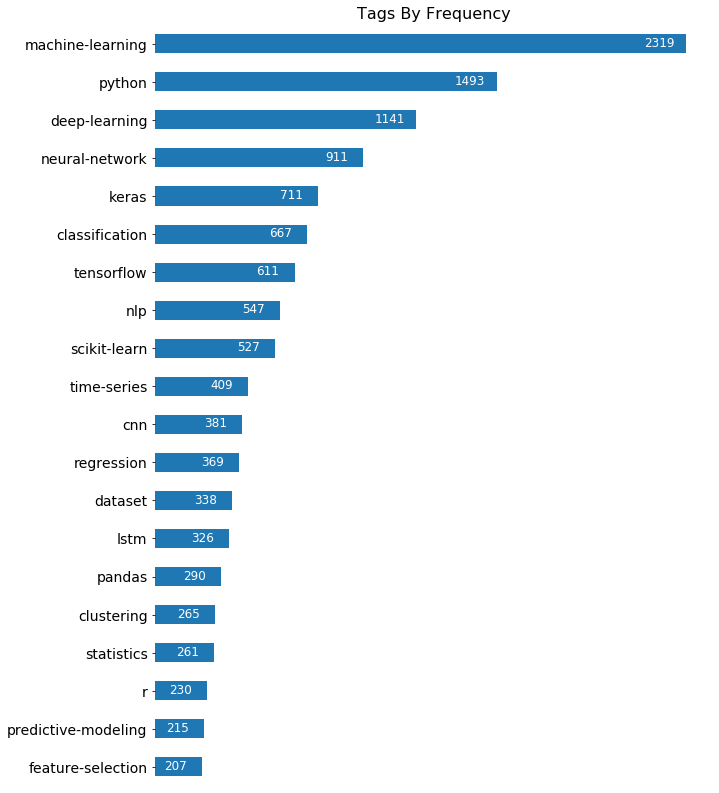

In [18]:
y_axis_values = tags_pt.sort_values(by='Number of Appearances', ascending=False).head(20).index[::-1]
x_axis_values = tags_pt.sort_values(by='Number of Appearances', ascending=False).head(20)['Number of Appearances'][::-1]
title = 'Tags By Frequency'

barplot(x_axis_values, y_axis_values, title, 14, 12)

View top 10 tags by total views after Dec 31, 2019

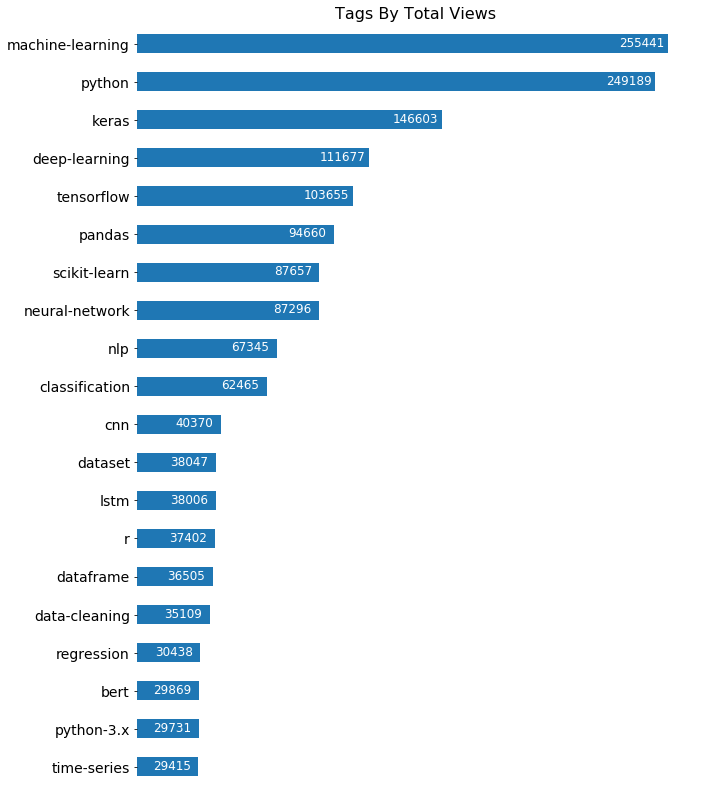

In [19]:
y_axis_values = tags_pt.sort_values(by='Sum of Views', ascending=False).head(20).index[::-1]
x_axis_values = tags_pt.sort_values(by='Sum of Views', ascending=False).head(20)['Sum of Views'][::-1]
title = 'Tags By Total Views'

barplot(x_axis_values, y_axis_values, title, 14, 12)

View top 10 tags by combined score

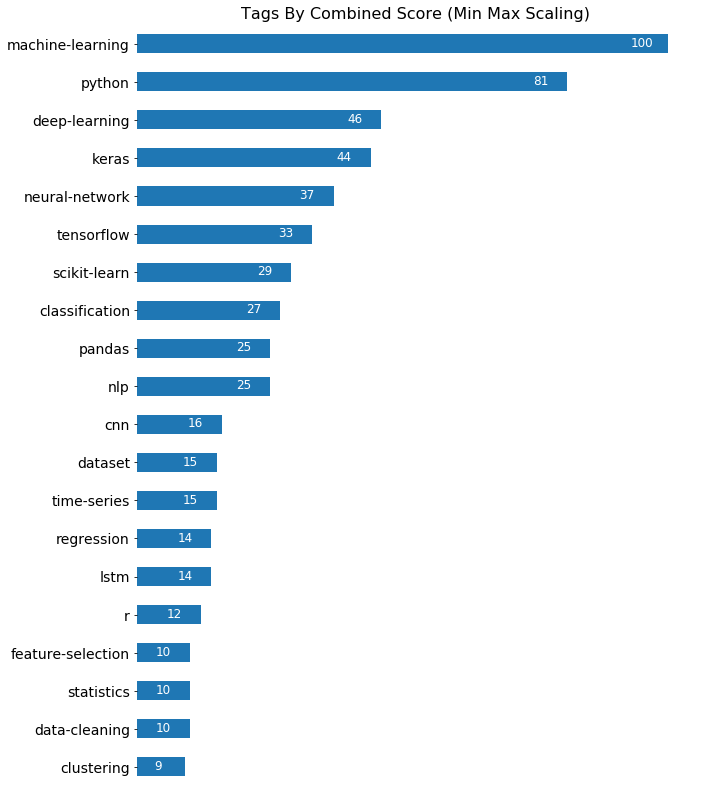

In [20]:
y_axis_values = tags_pt.sort_values(by='Score', ascending=False).head(20).index[::-1]
x_axis_values = tags_pt.sort_values(by='Score', ascending=False).head(20)['Score'][::-1]
title = 'Tags By Combined Score (Min Max Scaling)'

barplot(x_axis_values, y_axis_values, title, 14, 12)

[To Top](#Navigation)

### Analyzing and Visualizing Tag Relationships

For top 20 tags by score, we will create a heatmap showing the rate at which 2 tags appear together

In [21]:
combined_tags = list(tags_pt.sort_values(by='Score', ascending=False).head(20).index[::-1])
tag_with_tag_occurence_df = pd.DataFrame(index=combined_tags, columns=combined_tags)

Create functions to be used to mark rows as containing a single tag or two different tags

In [22]:
def check_single_tag_presence(self, tag):
    tag_match = self == tag
    return tag_match

In [23]:
def check_both_tags_presence(self, tag_1, tag_2):
    tag_match_1 = self == tag_1
    tag_match_2 = self == tag_2
    return tag_match_1 | tag_match_2

Get tag columns

In [24]:
tag_cols = [col for col in questions_df if col.startswith('Tag_')]

Create an empty dataframe to catch tags in top 20 that never occur together

In [25]:
never_occur_together = pd.DataFrame(columns=['Tag 1', 'Tag 2'])

Loop through data and top 20 tags
1. calculate the number of rows where a tag appears
2. calculate the number of rows where a second tag appears in conjunction with tag in 1)
3. divide 2) by 1) to get rate at which second tag appears when first tag is present

In [26]:
for first_tag in combined_tags:
    for second_tag in combined_tags:
        first_tag_present_by_row = questions_df[tag_cols].apply(check_single_tag_presence, args=[first_tag], axis=0)
        both_tags_present_by_row = questions_df[tag_cols].apply(check_both_tags_presence, args=[first_tag, second_tag], axis=0)
        first_tag_occurences_by_row = first_tag_present_by_row.apply(lambda tags: sum(tags) == 1, axis = 1)
        both_tags_occurences_by_row = both_tags_present_by_row.apply(lambda tags: sum(tags) == 2, axis = 1)
        combined_occurence_pct = sum(both_tags_occurences_by_row)/sum(first_tag_occurences_by_row)
        tag_with_tag_occurence_df.loc[first_tag, second_tag] = round(combined_occurence_pct * 100, 1)
        #populate dataframe to capture tags that neve occur together
        if combined_occurence_pct == 0 and first_tag != second_tag:
            never_occur_together = pd.concat([never_occur_together, pd.DataFrame(columns=['Tag 1', 'Tag 2'],
                                                                     data=[[first_tag, second_tag]])], axis=0)

Visualize tag with tag occurence rate

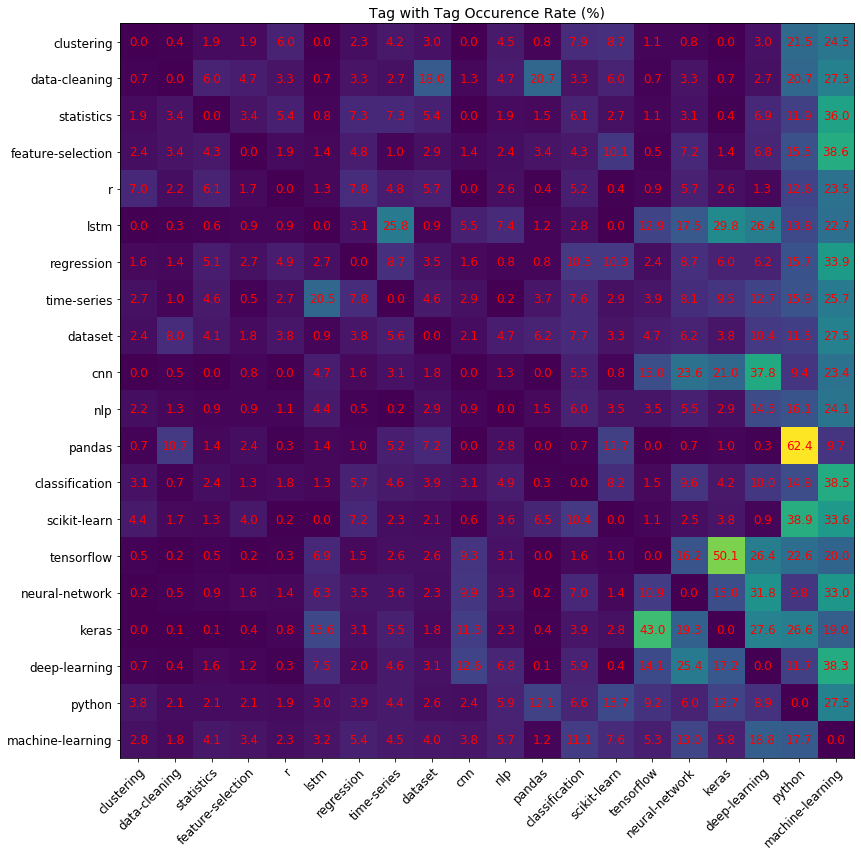

In [27]:
values = np.array(tag_with_tag_occurence_df.values, dtype=float)

fig, ax = plt.subplots(figsize=(14,12))
im = ax.imshow(values)

ax.set_xticks(np.arange(len(combined_tags)))
ax.set_yticks(np.arange(len(combined_tags)))
ax.set_xticklabels(combined_tags, size=12)
ax.set_yticklabels(combined_tags, size=12)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(combined_tags)):
    for j in range(len(combined_tags)):
        text = ax.text(j, i, values[i, j],
                       ha="center", va="center", color="r", size=12)

ax.set_title("Tag with Tag Occurence Rate (%)", size=14)
fig.tight_layout()
plt.show()

Here is how to interpret the heatmap: 
* when `clustering` tag is present, 0.4% of the time `data-cleaning` tag is also present.
* when `data-cleaning` tag is present, 0.7% of the time `clustering` tag is also present.
* etc.

Based on this data, we can see that on one end:
* when `pandas` tag is present, 62.4% of the time `python` tag is also present.
* when `tensorflow` tag is present, 50.1% of the time `keras` tag is also present.
* when `keras` tag is present, 43% of the time `tensorflow` tag is also present.

On the other end of the spectrum, the following and tags never occur together when we check the special dataframe we created:

In [28]:
never_occur_together

,Tag 1,Tag 2
0,clustering,lstm
0,clustering,cnn
0,clustering,keras
0,statistics,cnn
0,r,cnn
0,lstm,clustering
0,lstm,scikit-learn
0,cnn,clustering
0,cnn,statistics
0,cnn,r


Create a dataframe showing all top 20 tags and their top related tags (from the same list of top 20)

In [29]:
top_related_tags_df = pd.DataFrame(columns=['Tag', 'Top Related Tag', '2nd Related Tag', '3rd Related Tag'])

In [30]:
for col in combined_tags:
    sorted_series = tag_with_tag_occurence_df.loc[col, :].sort_values(ascending=False)
    top_tag = sorted_series.index[0] + ' - ' + str(sorted_series[0]) + '%'
    second_tag = sorted_series.index[1] + ' - ' + str(sorted_series[1]) + '%'
    third_tag = sorted_series.index[2] + ' - ' + str(sorted_series[2]) + '%'    
    top_related_tags_df = pd.concat([top_related_tags_df, pd.DataFrame(columns=top_related_tags_df.columns,
                                                                     data=[[col, 
                                                                            top_tag, 
                                                                            second_tag, 
                                                                            third_tag]])], axis=0)

View top 3 related tags by each tag (when Tag is present, top related tag is present x% of the time, etc)

In [31]:
top_related_tags_df

,Tag,Top Related Tag,2nd Related Tag,3rd Related Tag
0,clustering,machine-learning - 24.5%,python - 21.5%,scikit-learn - 8.7%
0,data-cleaning,machine-learning - 27.3%,pandas - 20.7%,python - 20.7%
0,statistics,machine-learning - 36.0%,python - 11.9%,time-series - 7.3%
0,feature-selection,machine-learning - 38.6%,python - 15.5%,scikit-learn - 10.1%
0,r,machine-learning - 23.5%,python - 12.6%,regression - 7.8%
0,lstm,keras - 29.8%,deep-learning - 26.4%,time-series - 25.8%
0,regression,machine-learning - 33.9%,python - 15.7%,scikit-learn - 10.3%
0,time-series,machine-learning - 25.7%,lstm - 20.5%,python - 15.9%
0,dataset,machine-learning - 27.5%,python - 11.5%,deep-learning - 10.4%
0,cnn,deep-learning - 37.8%,neural-network - 23.6%,machine-learning - 23.4%


We can sort the top 20 tags into 5 categories:
1. programming languages: python, r
2. broad subjects and their subsets: statistics (regression, time series), dataset
3. commonly occuring data science activities: data cleaning, clustering
4. popular libraries: pandas (for working with tabular data), scikit-learn (broader machine learning scope), tensorflow, keras (both narrower deep learning scope)
5. advanced data science concepts and techniques (and their subsets): classification, feature selection, machine learning (deep learning, nlp, neural network, cnn, lstm)

Here are my observations so far:
* `python` is in top 3 related tags for most top tags. `r` is never in top 3 related tags. 5 or 10 years ago, the 2 languages were neck in neck when it comes to data science applications. In fact, in many areas R was more popular. In general, `python` will likely drive more views to new content than `r`.
* Broad subjects and their subsets (category 2 above) are all appearing in the bottom of the top 20 list. There are more popular subjects to write about.
* The same can be said about commonly occuring data science activities like data cleaning and clustering.
* `pandas` is a more established and generic library for working with tabular data, is widely used and well documented. This may explain the reason why it trails other libraries in category 4 in the amount of questions and views.
* `scikit-learn` (a more generic data science library) is trailing both `tensorflow` and `keras`, two related libraries with a narrower deep learning focus. It seems like there is an opportunity to write specialized content that is related to `tensorflow` and `keras`.
* `machine learning` is the most popular tag, which makes sense because there are multiple subsets of the topic like deep learning, nlp, neural network, cnn, and lstm that are also very popular. Each time one of these subset tags appears by itself, it's likely to be tagged together with `machine learning`. All of these are good topics to write content about.
* when category 3 or 5 and category 4 tags appear together, it is a good sign that a library in category 4 is a good tool to perform an activity in category 3 or 5, for example: clustering - scikit-learn, data cleaning - pandas, lstm - keras. Notably, tensorflow is missing from this list despite its popularity. This is because `keras` is a user-friendly interface of `tensorflow` and may be easier to use to achive the same results.

[To Top](#Navigation)

### Analyzing the Deep Learning Trend

Let's check the popularity of the `deep learning` category over the years.

DSSE Data Explorer query to view all questions and tags:

<code>
SELECT Id, CreationDate, Tags
  FROM posts
 WHERE PostTypeId = 1;
</code>

The results are exported to `all_questions.csv` and loaded into a dataframe below. We will analyze the tags in a similar fashion that we used already, but this time we will focus on the deep learning subject and consider all questions since the site's launch as opposed to just 2020.

In [32]:
tag_history_df = pd.read_csv('all_questions.csv')
tag_history_df['CreationDate'] = tag_history_df['CreationDate'].astype('datetime64')

tag_history_df['Tags'] = tag_history_df['Tags'].str.replace('><', ',')
tag_history_df['Tags'] = tag_history_df['Tags'].str.replace('<', '')
tag_history_df['Tags'] = tag_history_df['Tags'].str.replace('>', '')

post_ids = pd.DataFrame(tag_history_df['Id'])
tags_df = pd.concat([post_ids, tag_history_df['Tags'].str.split(pat=',', expand=True)], axis=1)
cols = [f'Tag_{col}' for col in tags_df.columns if col != 'Id']
cols.insert(0, 'Id')
tags_df.columns = cols

tag_history_df.drop(columns='Tags', inplace=True)
tag_history_df = tag_history_df.merge(tags_df, left_on='Id', right_on='Id', how='inner')

tag_history_df = tag_history_df.melt(id_vars=['Id', 'CreationDate'], 
                          value_vars=['Tag_0', 'Tag_1', 'Tag_2', 'Tag_3', 'Tag_4'], value_name='Tag')
tag_history_df.drop(columns='variable', inplace=True)

Based on the information I gathered from the [Deep Learning](https://en.wikipedia.org/wiki/Deep_learning) article on Wikipedia and [Top 13 Python Deep Learning Libraries](https://www.kdnuggets.com/2018/11/top-python-deep-learning-libraries.html) article on KDNuggets, the following tags can be considered as deep learning subjects:

In [33]:
deep_learning_tags = ['deep-learning', 'neural-network', 'cnn', 'rnn', 'computer-vision', 'nlp', 'audio-recognition',
                      'machine-translation', 'ann', 'image-recognition', 'recommender-system', 'reinforcement-learning',
                      'tensorflow', 'keras', 'theano', 'pytorch', 'caffe', 'nltk', 'mxnet']

Continue with data transformation by marking rows with deep learning tags and extracting year from creation date. Years that are incomplete need to be filtered out.

In [34]:
def is_deep_learning(tag):
    return 1 if tag in deep_learning_tags else 0

In [35]:
tag_history_df['DeepLearningTags'] = tag_history_df['Tag'].apply(is_deep_learning)
tag_history_df['Year'] = tag_history_df['CreationDate'].dt.year
tag_history_df = tag_history_df[tag_history_df['Year'].isin([2015, 2016, 2017, 2018, 2019, 2020])]

Calculate total number of deep learning tag uses per year in absolute terms as well as relative to total number of data science questions asked

In [36]:
tag_history_pt = tag_history_df.pivot_table(index='Year', values='DeepLearningTags', aggfunc=('size', 'sum'))
tag_history_pt['Percent Deep Learning'] = round((tag_history_pt['sum'] / tag_history_pt['size']) * 100, 1)
tag_history_pt

,size,sum,Percent Deep Learning
Year,,,
2015,5810,242,4.2
2016,10580,863,8.2
2017,14595,1735,11.9
2018,26800,3891,14.5
2019,33905,4269,12.6
2020,38055,4956,13.0


Visualize our findings

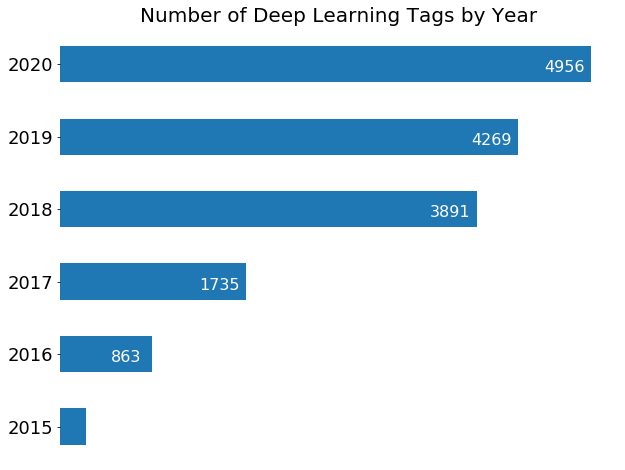

In [37]:
y_axis_values = tag_history_pt.index
x_axis_values = tag_history_pt['sum']
title = 'Number of Deep Learning Tags by Year'

barplot(x_axis_values, y_axis_values, title, 8, 16)

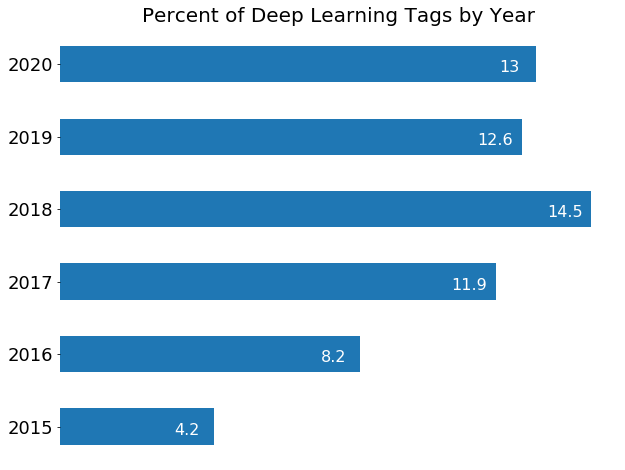

In [38]:
y_axis_values = tag_history_pt.index
x_axis_values = tag_history_pt['Percent Deep Learning']
title = 'Percent of Deep Learning Tags by Year'

barplot(x_axis_values, y_axis_values, title, 8, 16)

[To Top](#Navigation)

### Analyzing the Popularity of Python and R Over Time

I am curious to analyze the popularity of `r` and `python` over the same timeframe

In [39]:
def is_python(tag):
    return 1 if tag == 'python' else 0

def is_r(tag):
    return 1 if tag == 'r' else 0

In [40]:
tag_history_df['PythonTag'] = tag_history_df['Tag'].apply(is_python)
tag_history_df['RTag'] = tag_history_df['Tag'].apply(is_r)
tag_history_pt = tag_history_df.pivot_table(index='Year', values=['PythonTag', 'RTag'], aggfunc=('size', 'sum'))
tag_history_pt['Percent Python Tags'] = round((tag_history_pt[('PythonTag', 'sum')] / tag_history_pt[('PythonTag', 'size')]) * 100, 1)
tag_history_pt['Percent R Tags'] = round((tag_history_pt[('RTag', 'sum')] / tag_history_pt[('RTag', 'size')]) * 100, 1)
tag_history_pt

PythonTag         RTag      Percent Python Tags Percent R Tags
          size   sum   size  sum                                   
Year                                                               
2015      5810   130   5810  153                 2.2            2.6
2016     10580   313  10580  208                 3.0            2.0
2017     14595   471  14595  204                 3.2            1.4
2018     26800  1062  26800  199                 4.0            0.7
2019     33905  1448  33905  194                 4.3            0.6
2020     38055  1428  38055  220                 3.8            0.6

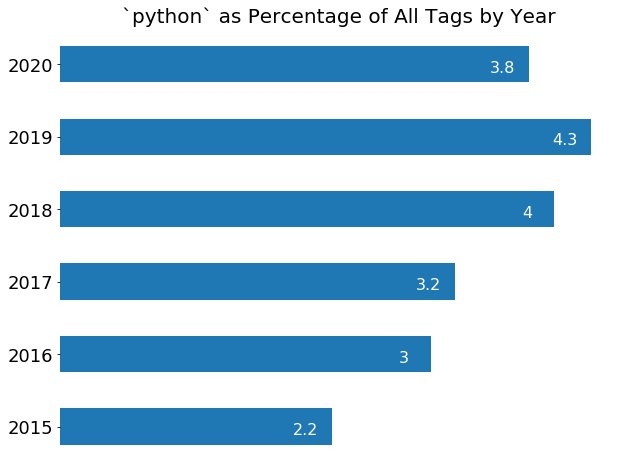

In [41]:
y_axis_values = tag_history_pt.index
x_axis_values = tag_history_pt[('Percent Python Tags', )]
title = '`python` as Percentage of All Tags by Year'

barplot(x_axis_values, y_axis_values, title, 8, 16)

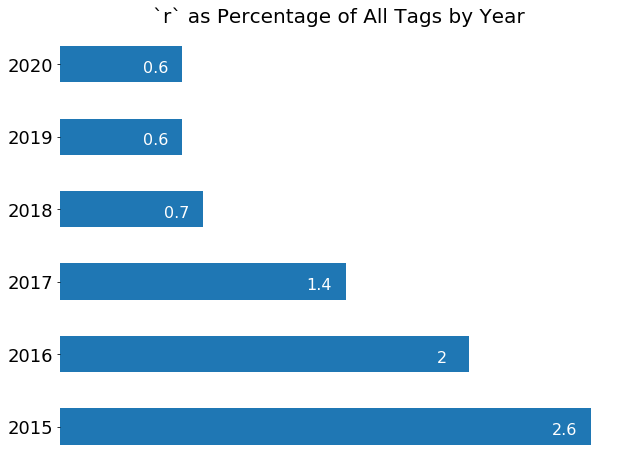

In [42]:
y_axis_values = tag_history_pt.index
x_axis_values = tag_history_pt[('Percent R Tags', )]
title = '`r` as Percentage of All Tags by Year'

barplot(x_axis_values, y_axis_values, title, 8, 16)

### Conclusion

The growth of deep learning, which is a subset of machine learning is not just a fad. My recommendation would be to write content about the following:
* concepts and techniques in machine learning (especially deep learning, neural networks, natural language processing, image recognition, speech recognition, convolutional neural networks, and long short-term memory)
* top python libraries used (especially keras, tensorflow, scikit-learn, and pandas, and which to use for a popular deep learning concept, as well as how)
* why certain concepts have become so popular, giving examples of their use to solve real world problems
* which big companies are using python for deep learning

The popularity of R is waning, while Python has grown over the years and remains strong.

We used views and tag frequency in our analysis. We could have also considered the number of votes and number of times marked as favorite

[To Top](#Navigation)